In [28]:
import os
import zipfile
import shutil
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
from PIL import Image
from keras import layers
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, DenseNet121
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img

In [2]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
image_dataset_folder = 'Berrijam Datasets/'
dataset_file = input("Enter the dataset filename: ")
if dataset_file == "Needs Respray":
    folder = zipfile.ZipFile(image_dataset_folder + "Data - Needs Respray - 2024-03-26.zip", "r")
    folder.extractall()
    folder.close()
    dataset_dir = "Data - Needs Respray - 2024-03-26"
elif dataset_file == "Is Epic Intro":
    folder = zipfile.ZipFile(image_dataset_folder + "Data - Is Epic Intro 2024-03-25.zip", "r")
    folder.extractall()
    folder.close()
    dataset_dir = "Data - Is Epic Intro 2024-03-25"
elif data_file == "Is GenAI":
    folder = zipfile.ZipFile(image_dataset_folder + "Data - Is GenAI - 2024-03-25.zip", "r")
    folder.extractall()
    folder.close()
    dataset_dir = "Data - Is GenAI - 2024-03-25"

EDA

In [ ]:
for filename in os.listdir(dataset_dir):
  if filename.endswith('g'):
    img_path = os.path.join(dataset_dir, filename)
    img = Image.open(img_path)
    img_array = np.array(img)
    print(f"Image: {filename}")
    print(f"Min pixel value: {np.min(img_array)}")
    print(f"Max pixel value: {np.max(img_array)}\n")

The image have pixel values ranging from 0 to 249 or 0 to 250 instead of the expected range of 0 to 255. To ensure that all images have pixel values in the range of 0 to 255, we have to normalize the images to rescale the pixel values accordingly.

In [ ]:
for filename in os.listdir(dataset_dir):
    if filename.endswith('g'):
        img_path = os.path.join(dataset_dir, filename)
        img = Image.open(img_path)
        img_array = np.array(img)
        img_array = (img_array / np.max(img_array)) * 255
        img_array = img_array.astype(np.uint8)
        
        print(f"Image: {filename}")
        
        print(f"Min pixel value: {np.min(img_array)}")
        print(f"Max pixel value: {np.max(img_array)}\n")

        img = Image.fromarray(img_array)
        img.save(img_path)
        print(f"{filename} has been updated and saved.\n")

The pixel values of all the images have been rescaled to the range of 0 to 255 and saved in the original directory by overwriting the original images with the updated pixel values.

Image Augmentation

In [3]:
Labels = pd.read_csv("Data - Needs Respray - 2024-03-26/Labels-NeedsRespray-2024-03-26.csv")
label_names = Labels.iloc[:, 0]
expanded_labels = pd.get_dummies(Labels["Needs Respray"])
expanded_labels = expanded_labels.astype('bool')
frames = [label_names, expanded_labels]
df = pd.concat(frames, axis = 1)
folder_names = Labels["Needs Respray"].unique()

copy_from = "Data - Needs Respray - 2024-03-26/"
if os.path.exists('Images') == False:
    os.mkdir('Images')
    
if os.path.exists('Images/Train') == False:
    os.mkdir('Images/Train')

if os.path.exists('Images/Test') == False:
    os.mkdir('Images/Test')

copy_to = 'Images/'

for name in folder_names:
    if os.path.exists(copy_to + 'Train/' + name) == False:
        os.mkdir(copy_to + 'Train/' + name)
    if os.path.exists(copy_to + 'Test/' + name) == False:
        os.mkdir(copy_to + 'Test/' + name)


for name in folder_names:
    files = df.Filename[df[name] == True]
    num_samples = len(files)
    num_train_samples = round(num_samples * 0.8)
    i = 0
    for f in files:
        path_from = copy_from + f
        if i < num_train_samples:
            path_to = copy_to + 'Train/' + name + '/' + f
        else:
            path_to = copy_to + 'Test/' + name + '/' + f
        shutil.copyfile(path_from, path_to)
        i += 1

In [4]:
import tensorflow as tf
import os

IMAGE_HEIGHT = 900
IMAGE_WIDTH = 1200

# Define the augmentation layers
data_augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(0.4, 0.4),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.GaussianNoise(30)
])

def augment_and_resize(image):
    # Apply augmentations and then resize
    augmented = data_augmentation_layers(image, training=True)
    resized = tf.image.resize(augmented, [IMAGE_HEIGHT, IMAGE_WIDTH])
    return resized
    
def load_and_preprocess_image(file_path):
    # Load, decode, and preprocess the image
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH]) 
    image = tf.reshape(image, [IMAGE_HEIGHT, IMAGE_WIDTH, 3])
    return image

def generate_multiple_augmented_samples(image, num_samples):
    # Generate 10 augmented samples for a single image
    return tf.data.Dataset.from_tensors(image).repeat(num_samples).map(
        augment_and_resize, num_parallel_calls=tf.data.AUTOTUNE)

def augment_and_save_dataset(image_dir, save_dir, num_samples=10):
    classes = os.listdir(image_dir)
    for class_name in classes:
        class_path = os.path.join(image_dir, class_name)
        save_class_path = os.path.join(save_dir, class_name)
        os.makedirs(save_class_path, exist_ok=True)

        dataset = tf.data.Dataset.list_files(os.path.join(class_path, '*g'), shuffle=False)
        dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        
        # Use flat_map to apply the generate_multiple_augmented_samples function with num_samples
        dataset = dataset.flat_map(lambda image: generate_multiple_augmented_samples(image, num_samples))
        
        # Batch and save images
        dataset = dataset.batch(1)  # Batch each image individually if saving separately
        i = 0  # Reset counter for each class
        for batch in dataset:
            save_path = os.path.join(save_class_path, f"aug_{class_name}_{i}.png")
            tf.keras.utils.save_img(save_path, batch[0].numpy())
            i += 1

In [5]:
%%time
img_dir_train = 'Images/Train/'
save_dir_train = 'Images/Train/'
img_dir_test = 'Images/Test/'
save_dir_test = 'Images/Test/'
augment_and_save_dataset(img_dir_train, save_dir_train, num_samples = 100)
augment_and_save_dataset(img_dir_test, save_dir_test, num_samples = 5)

CPU times: total: 7min 9s
Wall time: 2min 29s


Splitting the Data into Training and Validation set

In [6]:
train_dir = 'Images/Train/'
test_dir = 'Images/Test/'
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1./255)
BATCH_SIZE = 32

Defining parameters

In [7]:
def step_decay_schedule(initial_lr, decay_factor=0.1, step_size=10):
  def schedule(epoch):
    return initial_lr * (decay_factor ** np.floor(epoch / step_size))
    
  return LearningRateScheduler(schedule)

In [12]:
n_epochs = 10
learning_rate = 0.001
decay_factor = 0.5
step_size = 5

regularization_strengths = [0.0001, 0.0005, 0.001]
optimizers = ['Adam', 'RMSprop', 'SGD']

Observing VGG16 model performance on different parameters

In [13]:
input_shape_vgg16 = (224, 224, 3)

training_data_vgg16 = train_datagen.flow_from_directory(directory = train_dir, target_size = (224, 224), color_mode = 'rgb', batch_size = BATCH_SIZE, class_mode = 'binary', subset='training', shuffle = True, seed = 42)
validation_data_vgg16 = train_datagen.flow_from_directory(directory = train_dir, target_size = (224, 224), color_mode = 'rgb', batch_size = BATCH_SIZE, class_mode = 'binary', subset='validation', shuffle = True, seed = 42)
testing_data_vgg16 = test_datagen.flow_from_directory(directory = test_dir, target_size = (224, 224), color_mode = 'rgb', class_mode = 'binary', shuffle = False, seed = 42)

n_steps = training_data_vgg16.samples // BATCH_SIZE
n_val_steps = validation_data_vgg16.samples // BATCH_SIZE

Found 808 images belonging to 2 classes.
Found 202 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


In [14]:
#VGG16
def create_model_vgg16(input_shape, optimizer, lr, reg_strength=0.3):
    if optimizer == 'SGD':
        opt = SGD(learning_rate=lr)
    elif optimizer == 'RMSprop':
        opt = Adam(learning_rate=lr)
    elif optimizer == 'Adam':
        opt = RMSprop(learning_rate=lr)
    
    conv_base = VGG16(include_top=False,
                      weights='imagenet',
                      input_shape=input_shape)
    
    for layer in conv_base.layers:
        layer.trainable = False
        
    top_model = conv_base.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(128, activation='relu', kernel_regularizer=l2(reg_strength))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(64, activation='relu', kernel_regularizer=l2(reg_strength))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(32, activation='relu', kernel_regularizer=l2(reg_strength))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(1, activation='sigmoid')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
    
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [15]:
results_vgg16 = []

for reg_strength in regularization_strengths:
    for optimizer in optimizers:
        print(f"Training with {optimizer}, reg_strength={reg_strength}")
        model_vgg16 = create_model_vgg16(input_shape_vgg16, optimizer, learning_rate, reg_strength=reg_strength)
        lr_scheduler = step_decay_schedule(learning_rate, decay_factor, step_size)
        history_vgg16 = model_vgg16.fit(training_data_vgg16,
                            validation_data=validation_data_vgg16,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            epochs=n_epochs,
                            callbacks=[lr_scheduler],
                            verbose=1)
        results_vgg16.append({'optimizer': optimizer,
                              'reg_strength': reg_strength,
                              'history': history_vgg16.history})
        

Training with Adam, reg_strength=0.0001
Epoch 1/10
25/25 [==============================] - 16s 608ms/step - loss: 0.8507 - accuracy: 0.6018 - val_loss: 0.7486 - val_accuracy: 0.4948 - lr: 0.0010
Epoch 2/10
25/25 [==============================] - 14s 575ms/step - loss: 0.6651 - accuracy: 0.6856 - val_loss: 0.6884 - val_accuracy: 0.5052 - lr: 0.0010
Epoch 3/10
25/25 [==============================] - 14s 577ms/step - loss: 0.5936 - accuracy: 0.7281 - val_loss: 0.6545 - val_accuracy: 0.5208 - lr: 0.0010
Epoch 4/10
25/25 [==============================] - 14s 578ms/step - loss: 0.6099 - accuracy: 0.7410 - val_loss: 0.6294 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/10
25/25 [==============================] - 15s 594ms/step - loss: 0.5398 - accuracy: 0.7700 - val_loss: 0.6136 - val_accuracy: 0.6302 - lr: 0.0010
Epoch 6/10
25/25 [==============================] - 14s 579ms/step - loss: 0.4912 - accuracy: 0.7861 - val_loss: 0.5563 - val_accuracy: 0.7917 - lr: 5.0000e-04
Epoch 7/10
25/25 [==

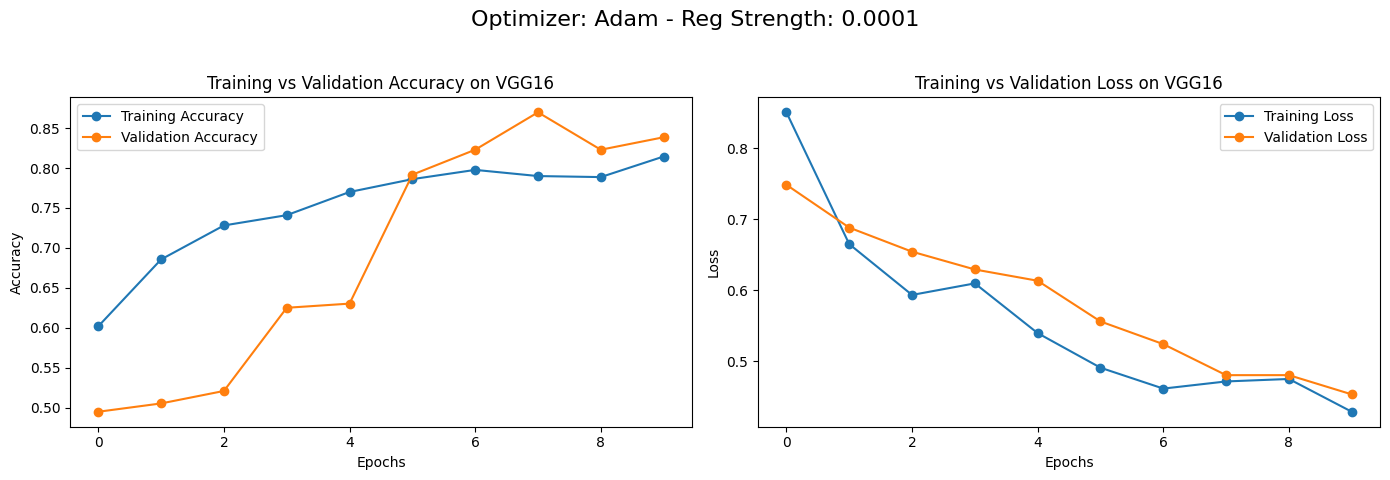

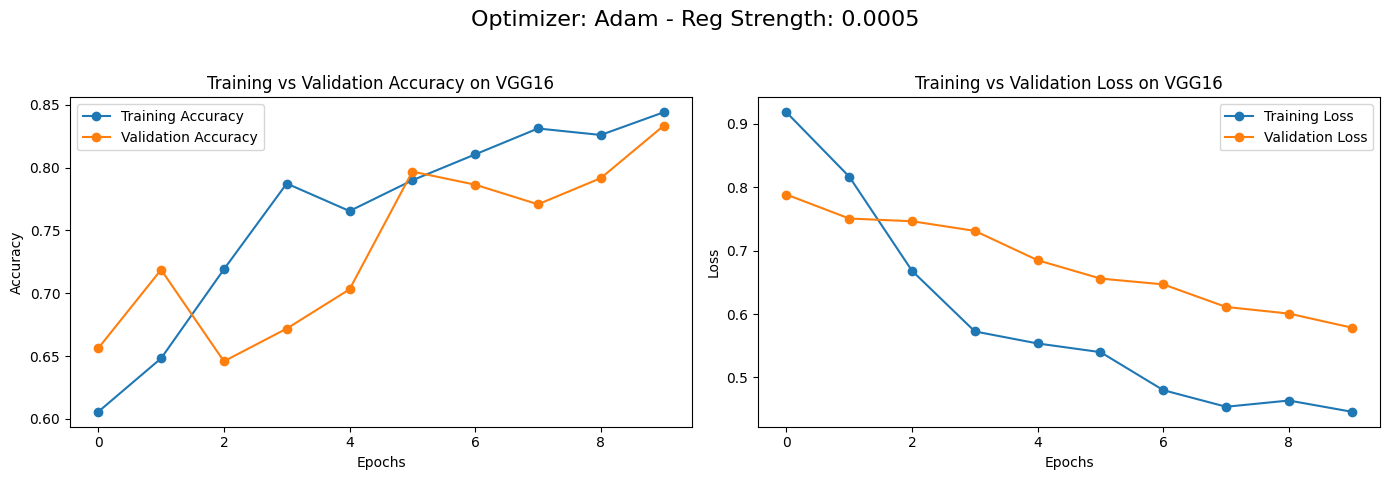

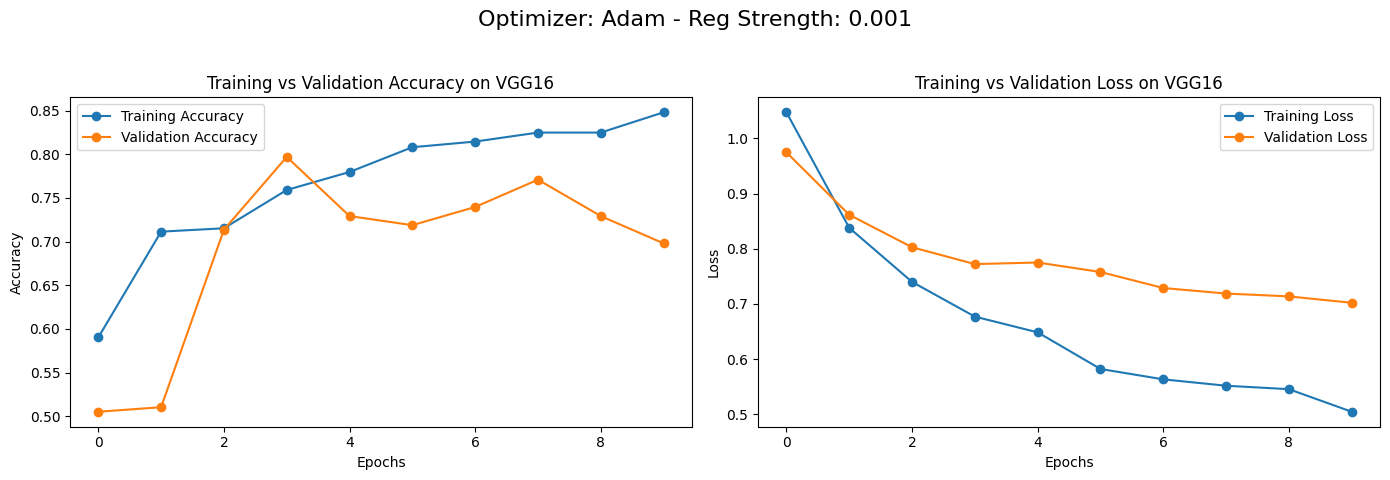

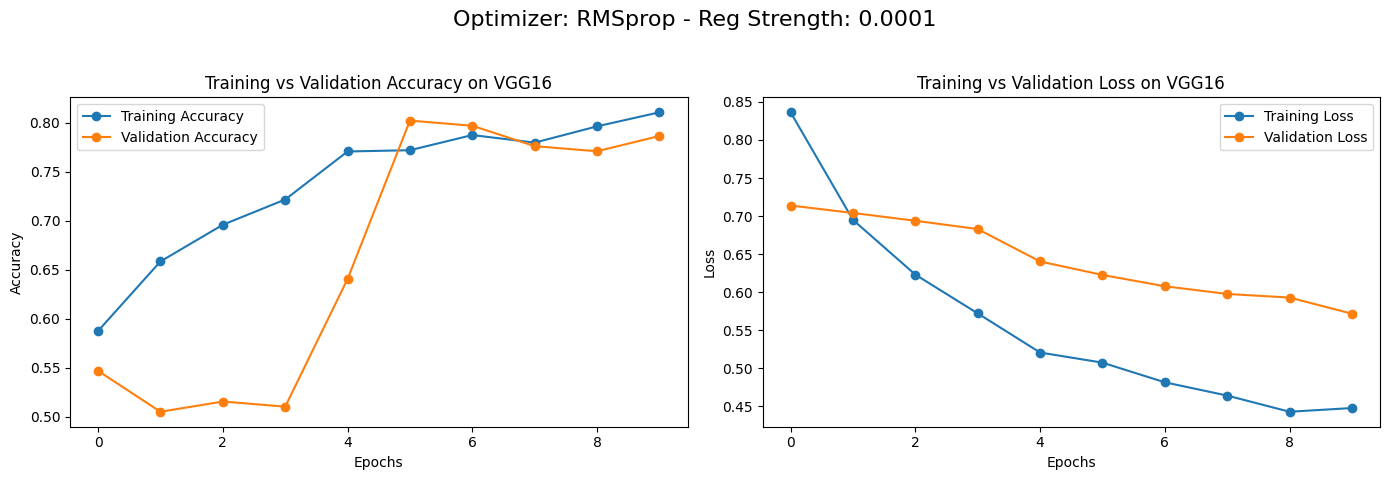

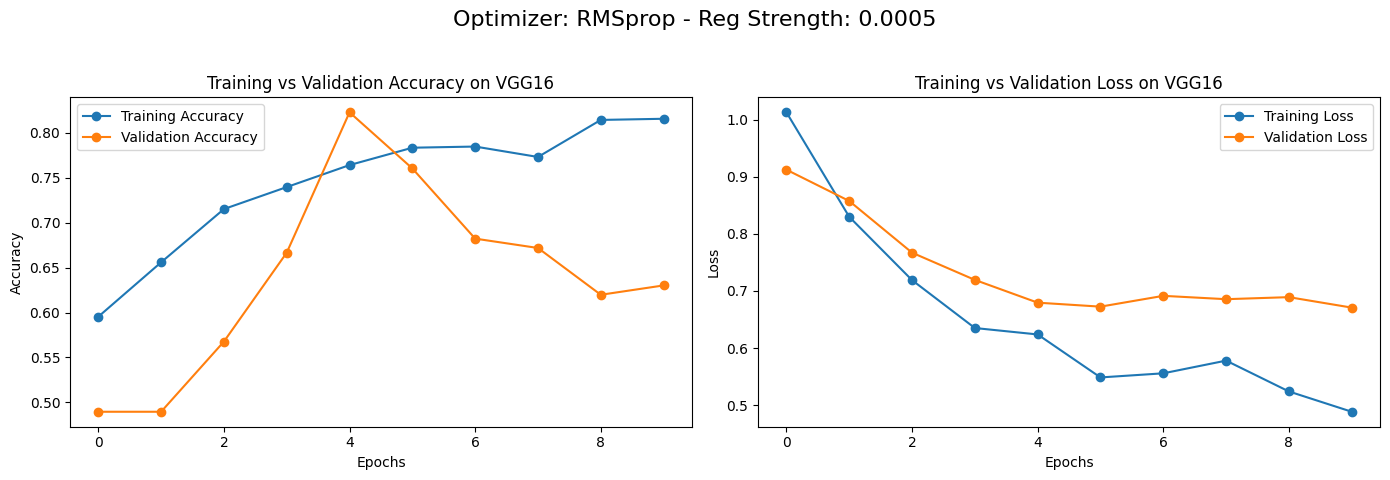

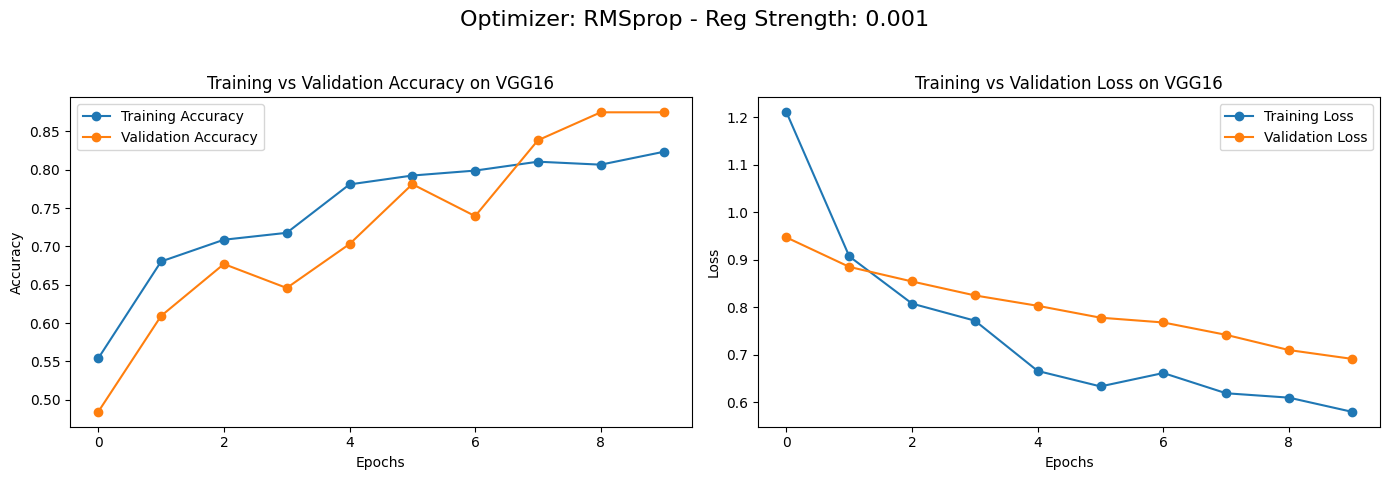

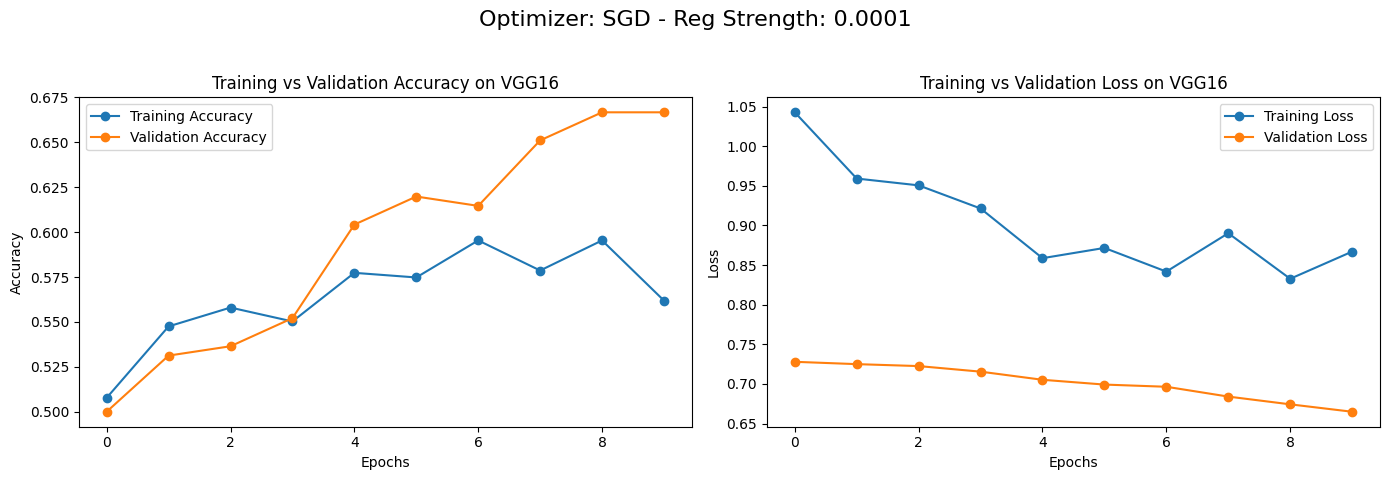

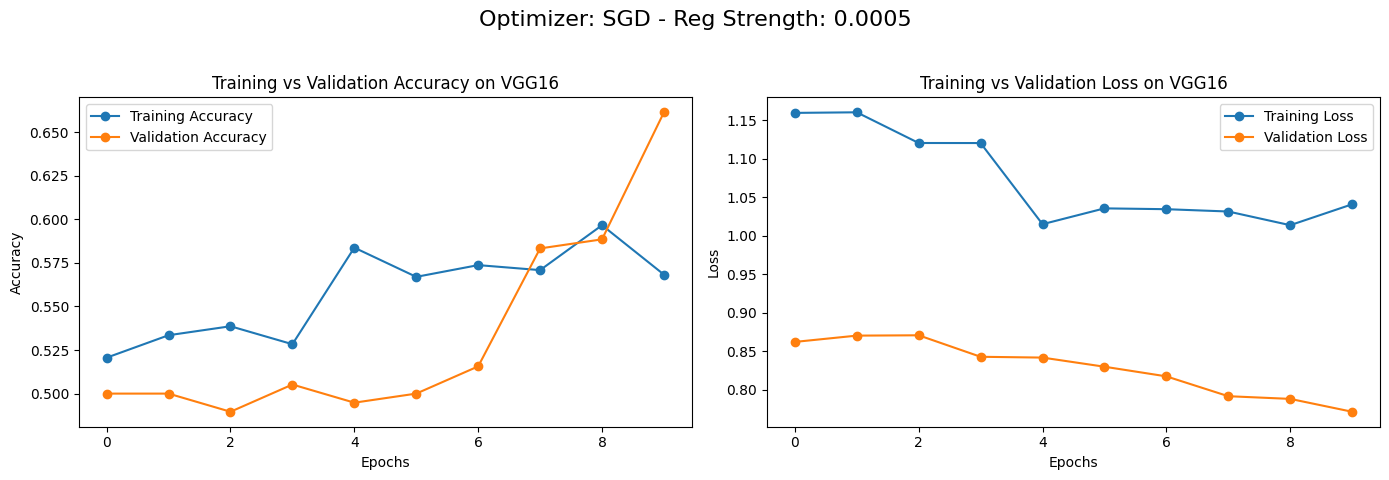

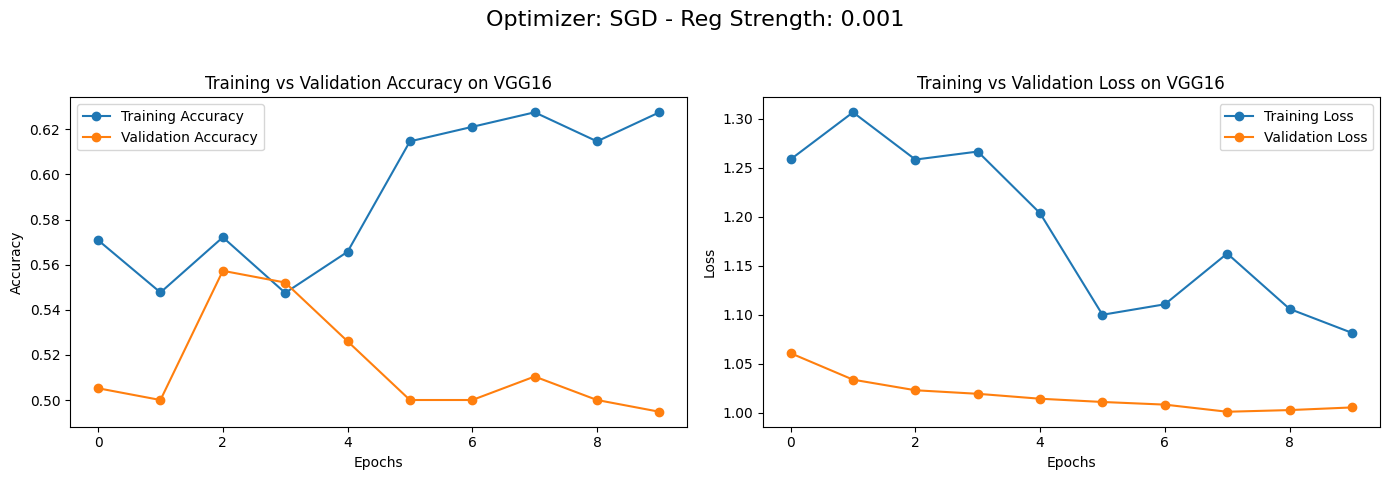

In [18]:
def plot_results_by_optimizer(optimizers, results):
    for optimizer in optimizers:
        optimizer_results = [r for r in results if r['optimizer'] == optimizer]
        for result in optimizer_results:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            fig.suptitle(f'Optimizer: {optimizer} - Reg Strength: {result["reg_strength"]}', fontsize=16)
            
            axes[0].plot(result['history']['accuracy'], label='Training Accuracy', marker='o')
            axes[0].plot(result['history']['val_accuracy'], label='Validation Accuracy', marker='o')
            axes[0].set_title('Training vs Validation Accuracy on VGG16')
            axes[0].set_xlabel('Epochs')
            axes[0].set_ylabel('Accuracy')
            axes[0].legend()
            
            axes[1].plot(result['history']['loss'], label='Training Loss', marker='o')
            axes[1].plot(result['history']['val_loss'], label='Validation Loss', marker='o')
            axes[1].set_title('Training vs Validation Loss on VGG16')
            axes[1].set_xlabel('Epochs')
            axes[1].set_ylabel('Loss')
            axes[1].legend()
            
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])

            save_path = "Plots/Needs Respray/VGG16/"
            fig.savefig(f"{save_path}{optimizer}_{result['reg_strength']}.png")
            
            plt.show()

plot_results_by_optimizer(optimizers, results_vgg16)

Observing Inception-v3 model performance on different parameters

In [19]:
input_shape_inceptionv3 = (299, 299, 3)

training_data_inceptionv3 = train_datagen.flow_from_directory(directory = train_dir, target_size = (299, 299), color_mode = 'rgb', batch_size = BATCH_SIZE, class_mode = 'binary', subset='training', shuffle = True, seed = 42)
validation_data_inceptionv3 = train_datagen.flow_from_directory(directory = train_dir, target_size = (299, 299), color_mode = 'rgb', batch_size = BATCH_SIZE, class_mode = 'binary', subset='validation', shuffle = True, seed = 42)
testing_data_inceptionv3 = test_datagen.flow_from_directory(directory = test_dir, target_size = (299, 299), color_mode = 'rgb', class_mode = 'binary', shuffle = False, seed = 42)

n_steps = training_data_inceptionv3.samples // BATCH_SIZE
n_val_steps = validation_data_inceptionv3.samples // BATCH_SIZE

Found 808 images belonging to 2 classes.
Found 202 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


In [20]:
#Inception-v3
def create_model_inceptionv3(input_shape, optimizer, lr, reg_strength=0.3):
    if optimizer == 'SGD':
        opt = SGD(learning_rate=lr)
    elif optimizer == 'RMSprop':
        opt = Adam(learning_rate=lr)
    elif optimizer == 'Adam':
        opt = RMSprop(learning_rate=lr)
    
    conv_base = InceptionV3(include_top=False,
                      weights='imagenet',
                      input_shape=input_shape)
    
    for layer in conv_base.layers:
        layer.trainable = False
        
    top_model = conv_base.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(128, activation='relu', kernel_regularizer=l2(reg_strength))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(64, activation='relu', kernel_regularizer=l2(reg_strength))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(32, activation='relu', kernel_regularizer=l2(reg_strength))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(1, activation='sigmoid')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
    
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [21]:
results_inceptionv3 = []

for reg_strength in regularization_strengths:
    for optimizer in optimizers:
        print(f"Training with {optimizer}, reg_strength={reg_strength}")
        model_inceptionv3 = create_model_inceptionv3(input_shape_inceptionv3, optimizer, learning_rate, reg_strength=reg_strength)
        lr_scheduler = step_decay_schedule(learning_rate, decay_factor, step_size)
        history_inceptionv3 = model_inceptionv3.fit(training_data_inceptionv3,
                            validation_data=validation_data_inceptionv3,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            epochs=n_epochs,
                            callbacks=[lr_scheduler],
                            verbose=1)
        results_inceptionv3.append({'optimizer': optimizer,
                        'reg_strength': reg_strength,
                        'history': history_inceptionv3.history})
        

Training with Adam, reg_strength=0.0001
Epoch 1/10
25/25 [==============================] - 21s 693ms/step - loss: 0.7683 - accuracy: 0.6418 - val_loss: 0.5431 - val_accuracy: 0.7344 - lr: 0.0010
Epoch 2/10
25/25 [==============================] - 16s 634ms/step - loss: 0.5874 - accuracy: 0.7552 - val_loss: 0.4756 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 3/10
25/25 [==============================] - 16s 644ms/step - loss: 0.4612 - accuracy: 0.7964 - val_loss: 0.4428 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 4/10
25/25 [==============================] - 16s 625ms/step - loss: 0.4296 - accuracy: 0.8131 - val_loss: 0.3586 - val_accuracy: 0.8802 - lr: 0.0010
Epoch 5/10
25/25 [==============================] - 15s 611ms/step - loss: 0.3185 - accuracy: 0.8827 - val_loss: 0.2778 - val_accuracy: 0.8958 - lr: 0.0010
Epoch 6/10
25/25 [==============================] - 15s 613ms/step - loss: 0.2958 - accuracy: 0.8814 - val_loss: 0.2180 - val_accuracy: 0.9219 - lr: 5.0000e-04
Epoch 7/10
25/25 [==

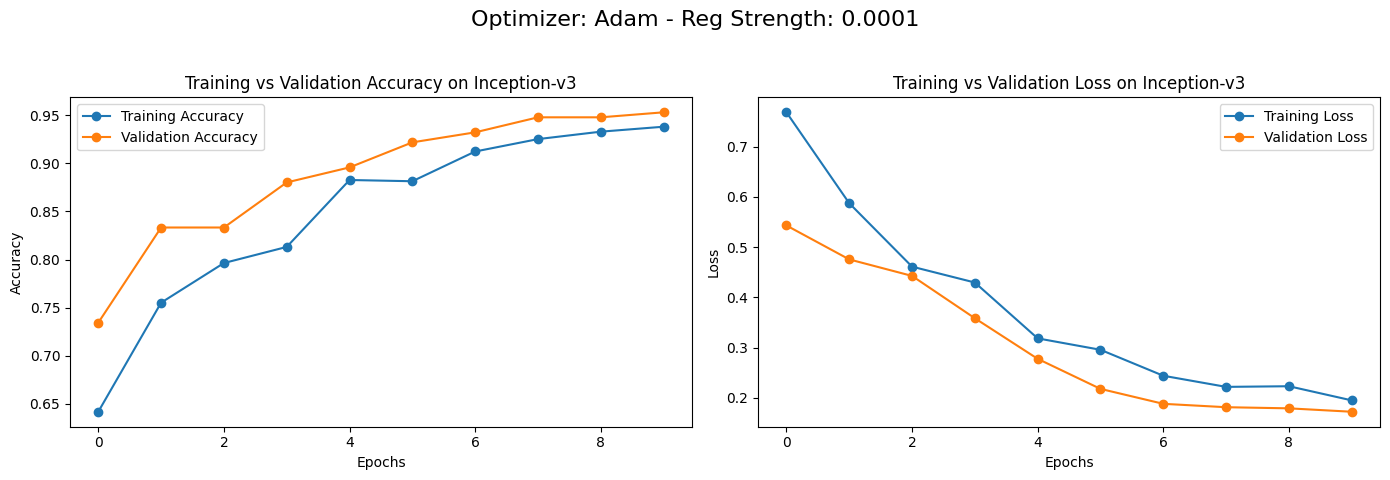

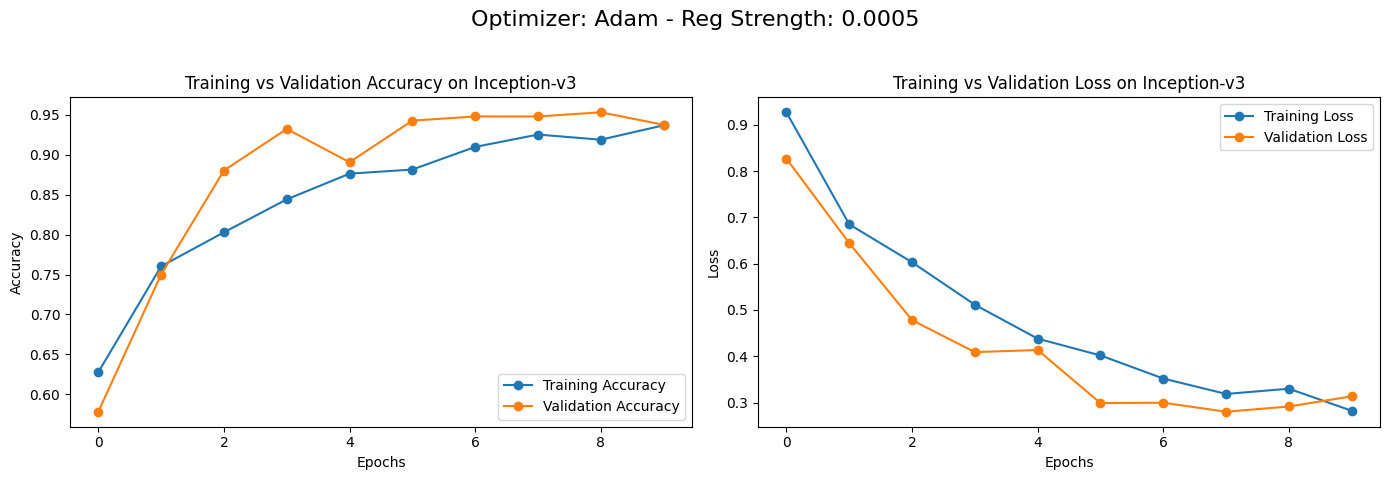

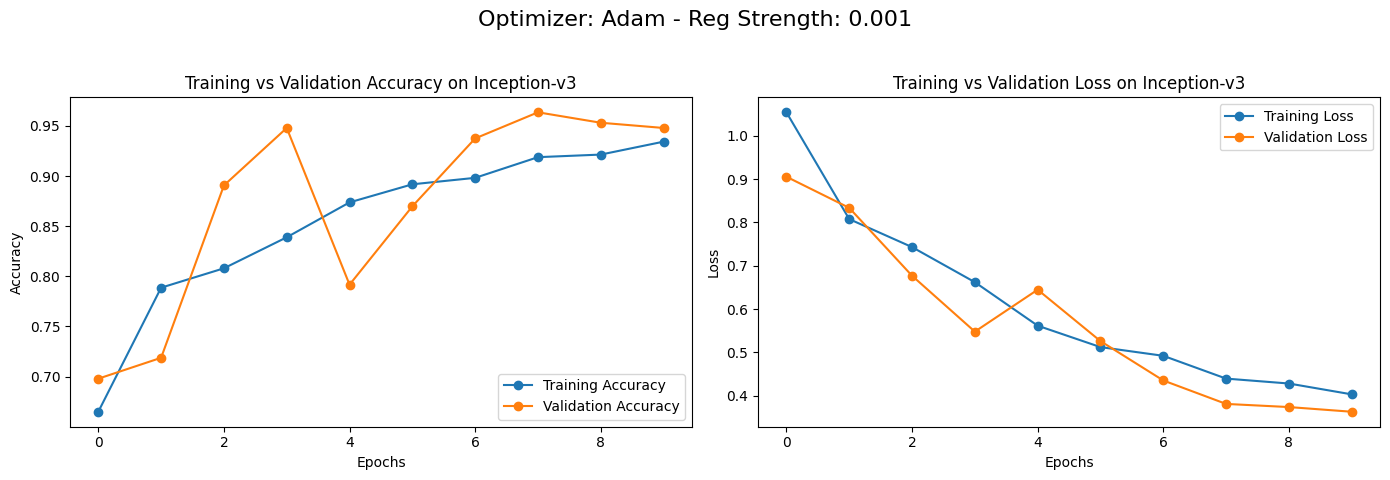

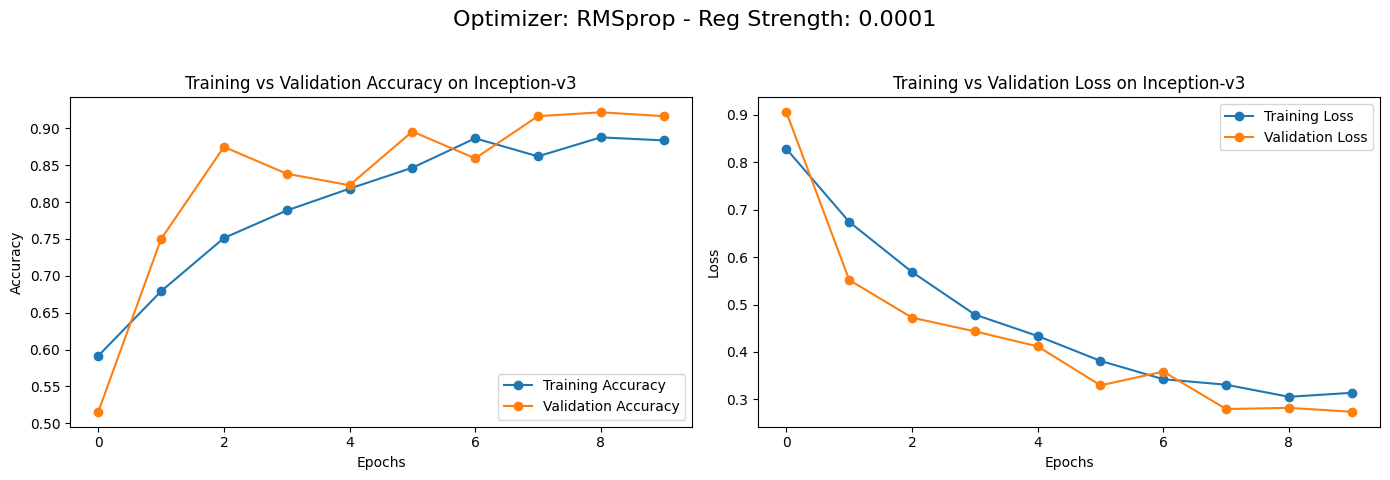

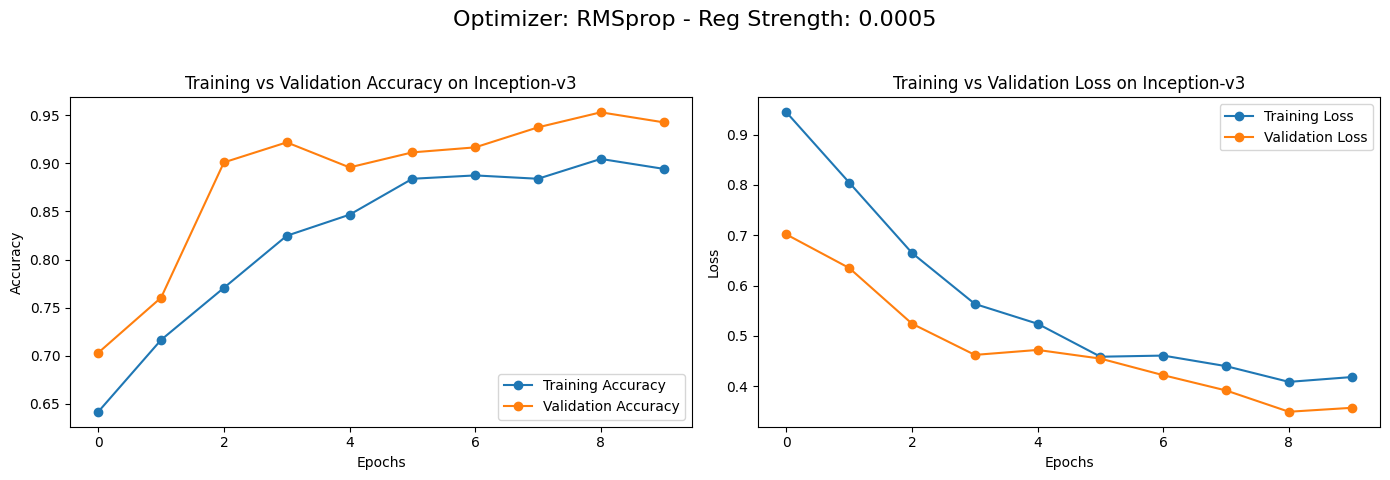

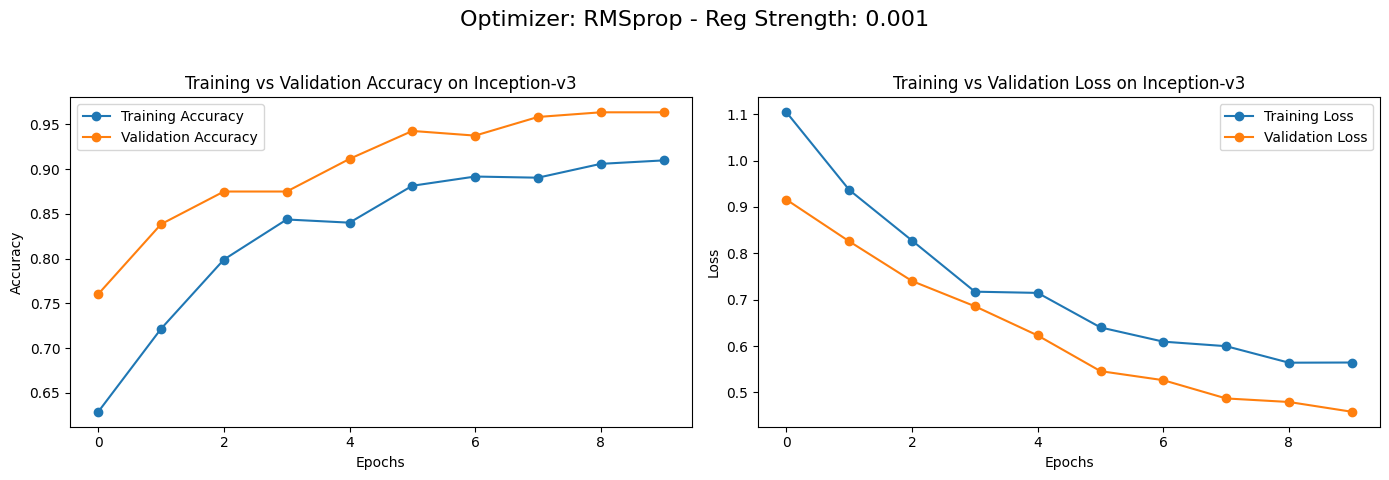

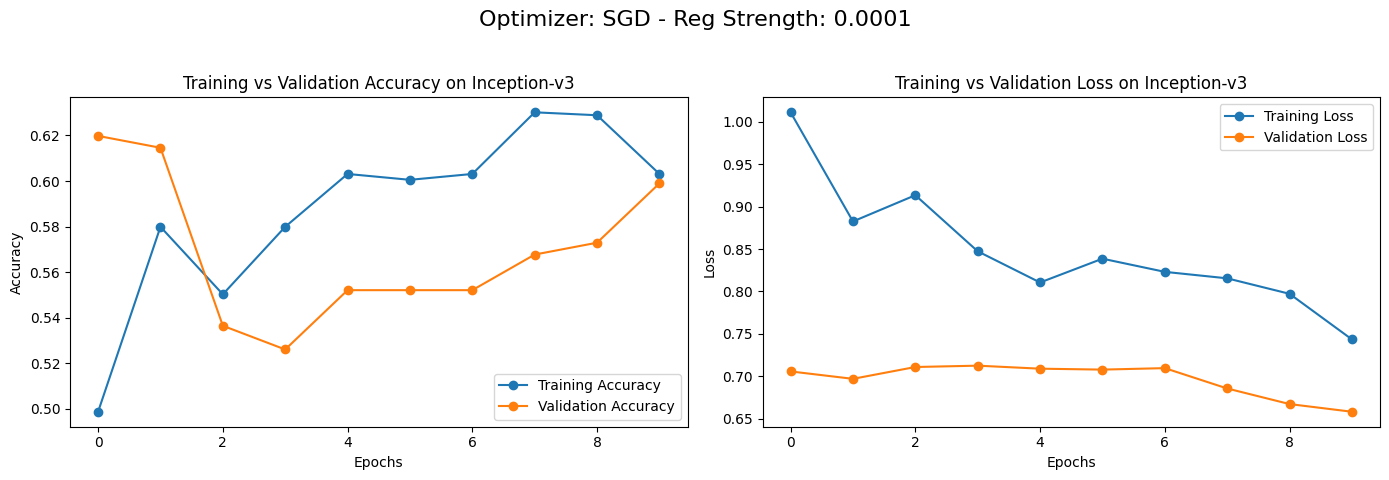

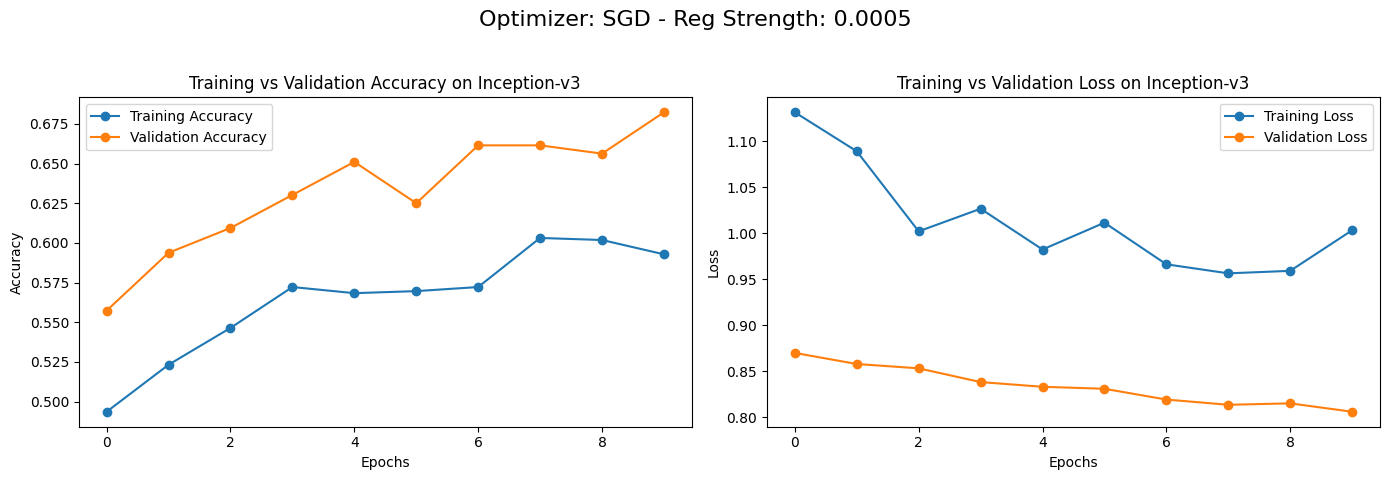

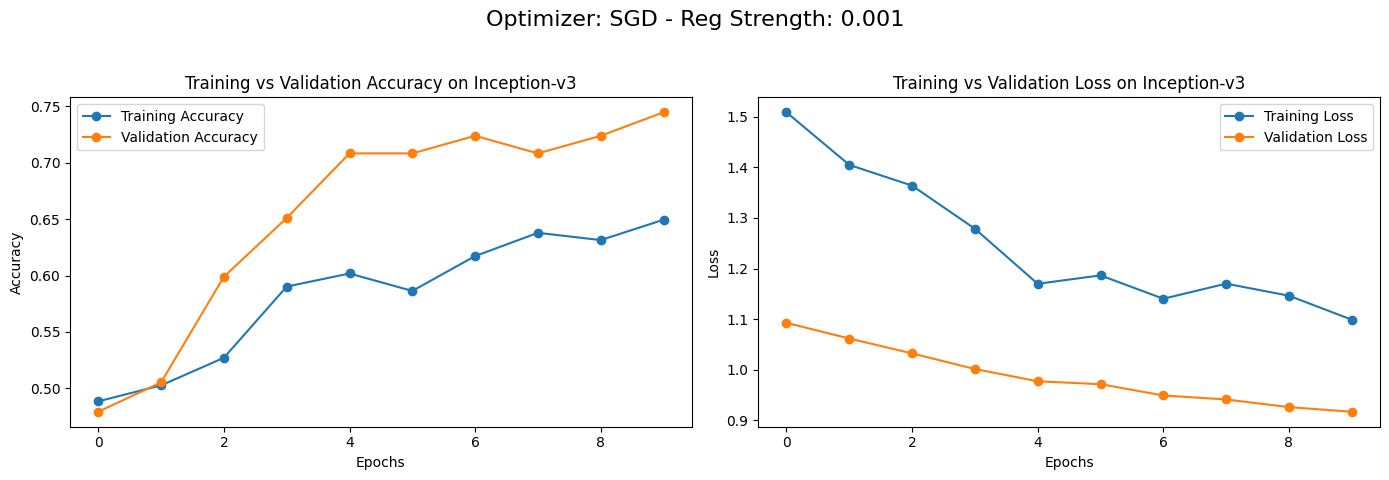

In [22]:
def plot_results_by_optimizer(optimizers, results):
    for optimizer in optimizers:
        optimizer_results = [r for r in results if r['optimizer'] == optimizer]
        for result in optimizer_results:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            fig.suptitle(f'Optimizer: {optimizer} - Reg Strength: {result["reg_strength"]}', fontsize=16)
            
            axes[0].plot(result['history']['accuracy'], label='Training Accuracy', marker='o')
            axes[0].plot(result['history']['val_accuracy'], label='Validation Accuracy', marker='o')
            axes[0].set_title('Training vs Validation Accuracy on Inception-v3')
            axes[0].set_xlabel('Epochs')
            axes[0].set_ylabel('Accuracy')
            axes[0].legend()
            
            axes[1].plot(result['history']['loss'], label='Training Loss', marker='o')
            axes[1].plot(result['history']['val_loss'], label='Validation Loss', marker='o')
            axes[1].set_title('Training vs Validation Loss on Inception-v3')
            axes[1].set_xlabel('Epochs')
            axes[1].set_ylabel('Loss')
            axes[1].legend()
            
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])

            save_path = "Plots/Needs Respray/InceptionV3/"
            fig.savefig(f"{save_path}{optimizer}_{result['reg_strength']}.png")
            
            plt.show()

plot_results_by_optimizer(optimizers, results_inceptionv3)

Observing DenseNet121 model performance on different parameters

In [23]:
input_shape_densenet = (224, 224, 3)

training_data_densenet = train_datagen.flow_from_directory(directory = train_dir, target_size = (224, 224), color_mode = 'rgb', batch_size = BATCH_SIZE, class_mode = 'binary', subset='training', shuffle = True, seed = 42)
validation_data_densenet = train_datagen.flow_from_directory(directory = train_dir, target_size = (224, 224), color_mode = 'rgb', batch_size = BATCH_SIZE, class_mode = 'binary', subset='validation', shuffle = True, seed = 42)
testing_data_densenet = test_datagen.flow_from_directory(directory = test_dir, target_size = (224, 224), color_mode = 'rgb', class_mode = 'binary', shuffle = False, seed = 42)

n_steps = training_data_densenet.samples // BATCH_SIZE
n_val_steps = validation_data_densenet.samples // BATCH_SIZE

Found 808 images belonging to 2 classes.
Found 202 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


In [24]:
#DenseNet
def create_model_densenet(input_shape, optimizer, lr, reg_strength=0.3):
    if optimizer == 'SGD':
        opt = SGD(learning_rate=lr)
    elif optimizer == 'RMSprop':
        opt = Adam(learning_rate=lr)
    elif optimizer == 'Adam':
        opt = RMSprop(learning_rate=lr)
    
    conv_base = DenseNet121(include_top=False,
                      weights='imagenet',
                      input_shape=input_shape)
    
    for layer in conv_base.layers:
        layer.trainable = False
        
    top_model = conv_base.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(128, activation='relu', kernel_regularizer=l2(reg_strength))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(64, activation='relu', kernel_regularizer=l2(reg_strength))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)    
    top_model = Dense(32, activation='relu', kernel_regularizer=l2(reg_strength))(top_model)
    top_model = BatchNormalization()(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(1, activation='sigmoid')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
    
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [25]:
results_densenet = []

for reg_strength in regularization_strengths:
    for optimizer in optimizers:
        print(f"Training with {optimizer}, reg_strength={reg_strength}")
        model_densenet = create_model_densenet(input_shape_densenet, optimizer, learning_rate, reg_strength=reg_strength)
        lr_scheduler = step_decay_schedule(learning_rate, decay_factor, step_size)
        history_densenet = model_densenet.fit(training_data_densenet,
                            validation_data=validation_data_densenet,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            epochs=n_epochs,
                            callbacks=[lr_scheduler],
                            verbose=1)
        results_densenet.append({'optimizer': optimizer,
                        'reg_strength': reg_strength,
                        'history': history_densenet.history})

Training with Adam, reg_strength=0.0001
29084464/29084464 [==============================] - 5s 0us/step
Epoch 1/10
25/25 [==============================] - 22s 656ms/step - loss: 0.7583 - accuracy: 0.6456 - val_loss: 0.5439 - val_accuracy: 0.8646 - lr: 0.0010
Epoch 2/10
25/25 [==============================] - 15s 609ms/step - loss: 0.6531 - accuracy: 0.7010 - val_loss: 0.4100 - val_accuracy: 0.8802 - lr: 0.0010
Epoch 3/10
25/25 [==============================] - 15s 618ms/step - loss: 0.5461 - accuracy: 0.7887 - val_loss: 0.3890 - val_accuracy: 0.8802 - lr: 0.0010
Epoch 4/10
25/25 [==============================] - 15s 596ms/step - loss: 0.4196 - accuracy: 0.8209 - val_loss: 0.2956 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 5/10
25/25 [==============================] - 15s 593ms/step - loss: 0.3336 - accuracy: 0.8621 - val_loss: 0.2644 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 6/10
25/25 [==============================] - 15s 606ms/step - loss: 0.3057 - accuracy: 0.8776 - val_loss: 0.

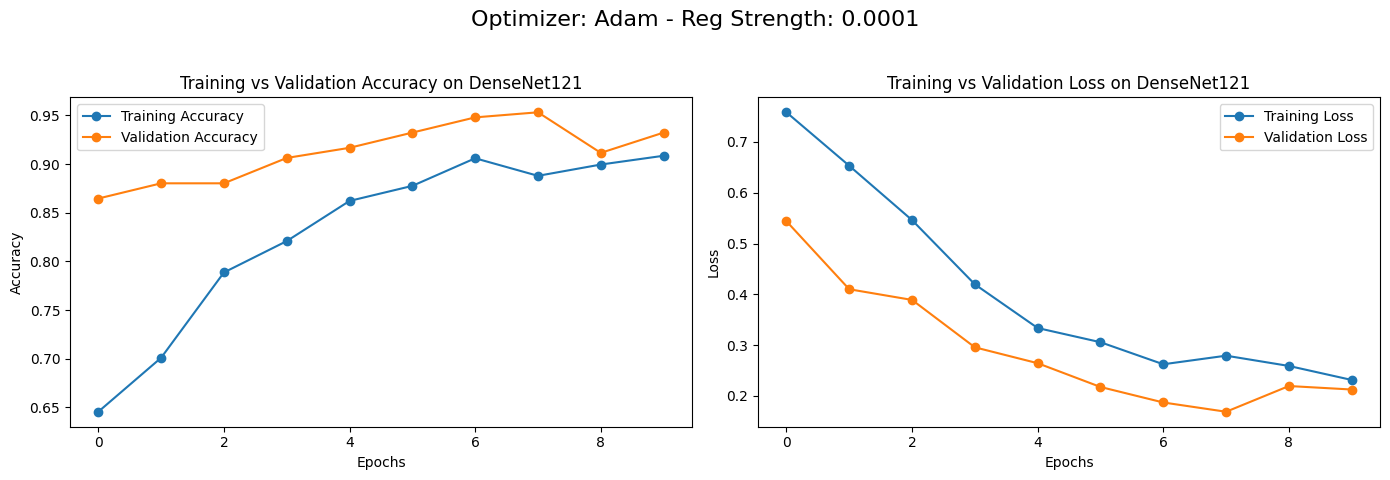

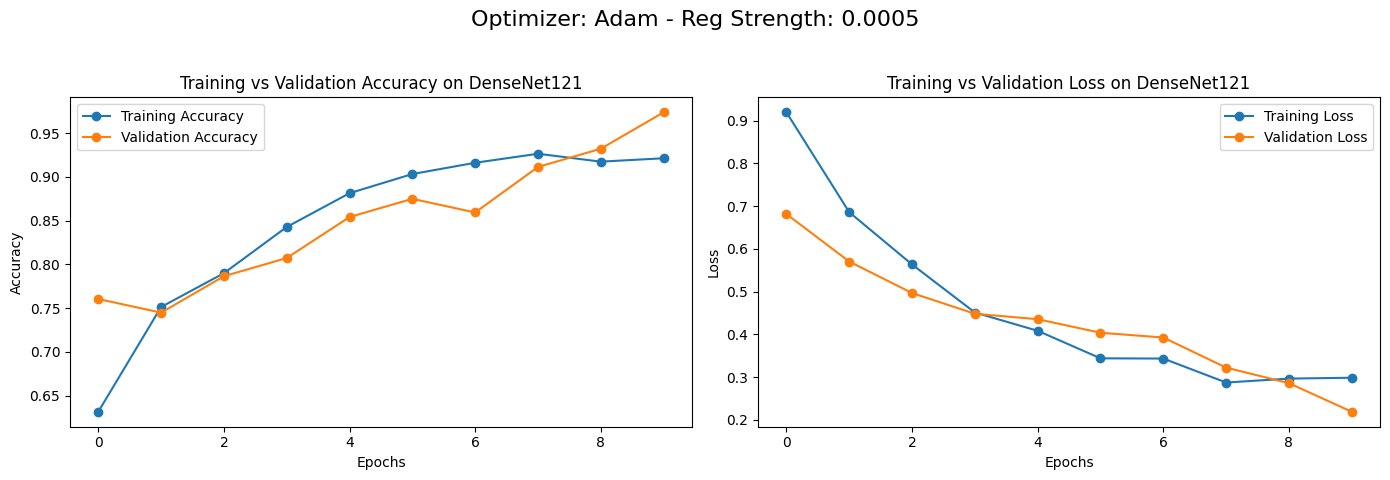

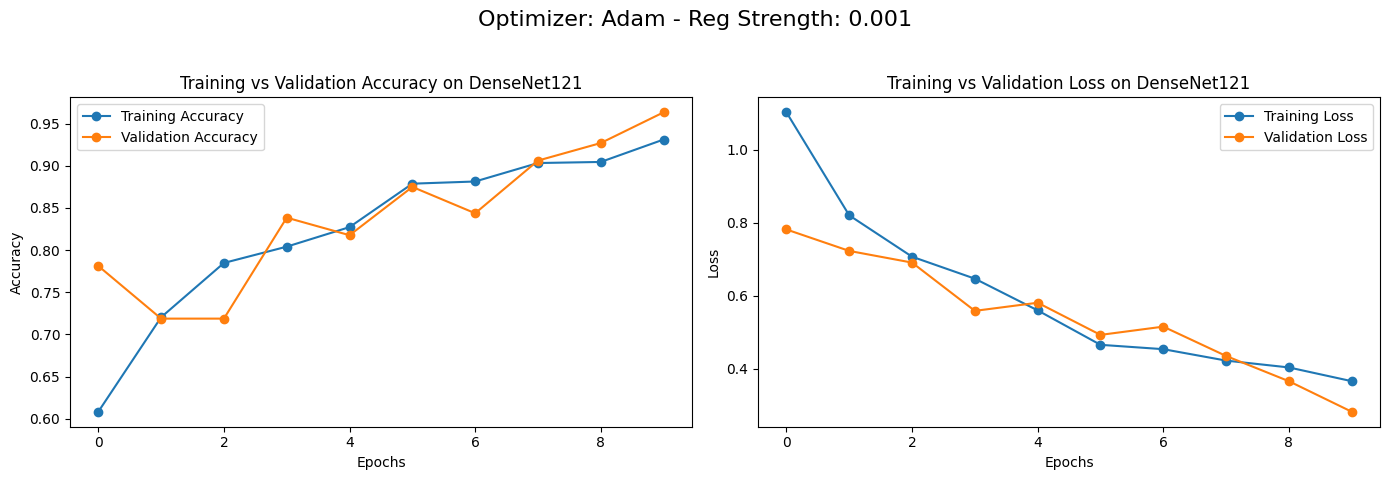

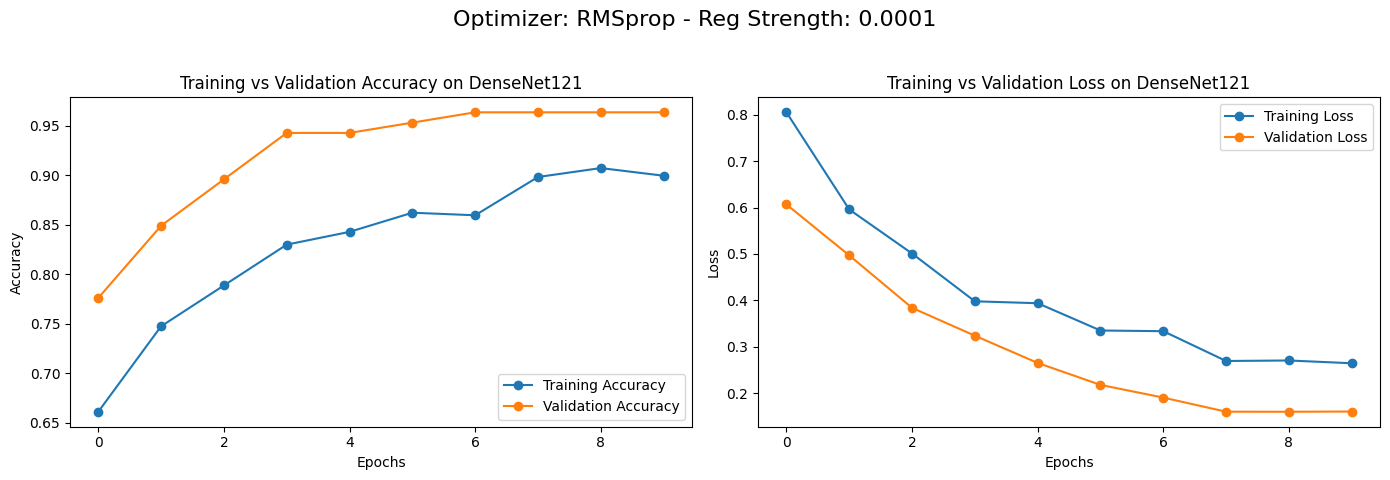

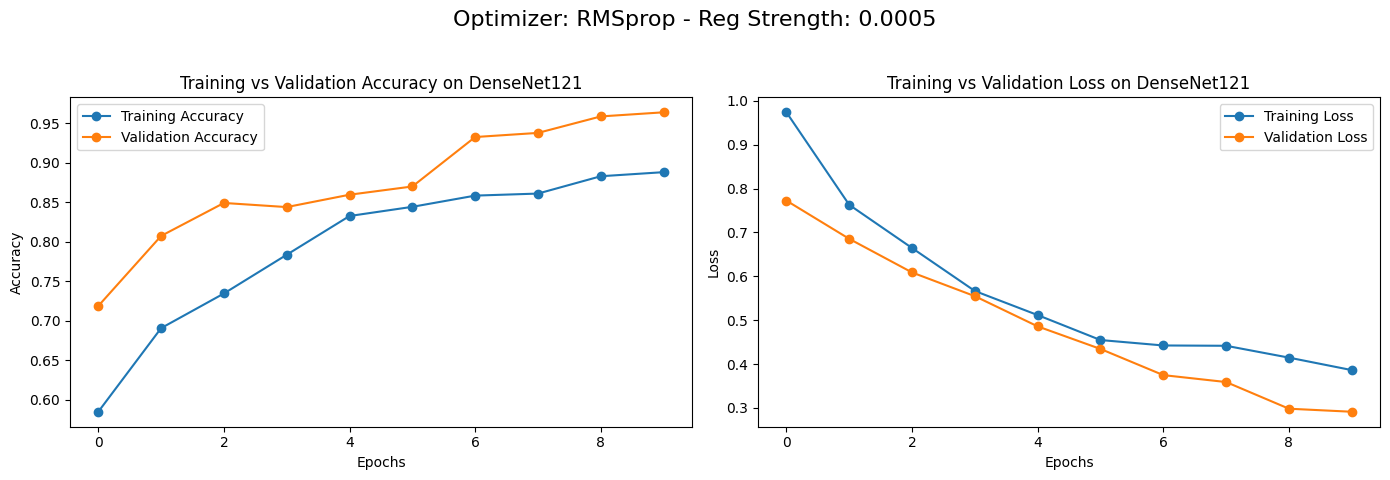

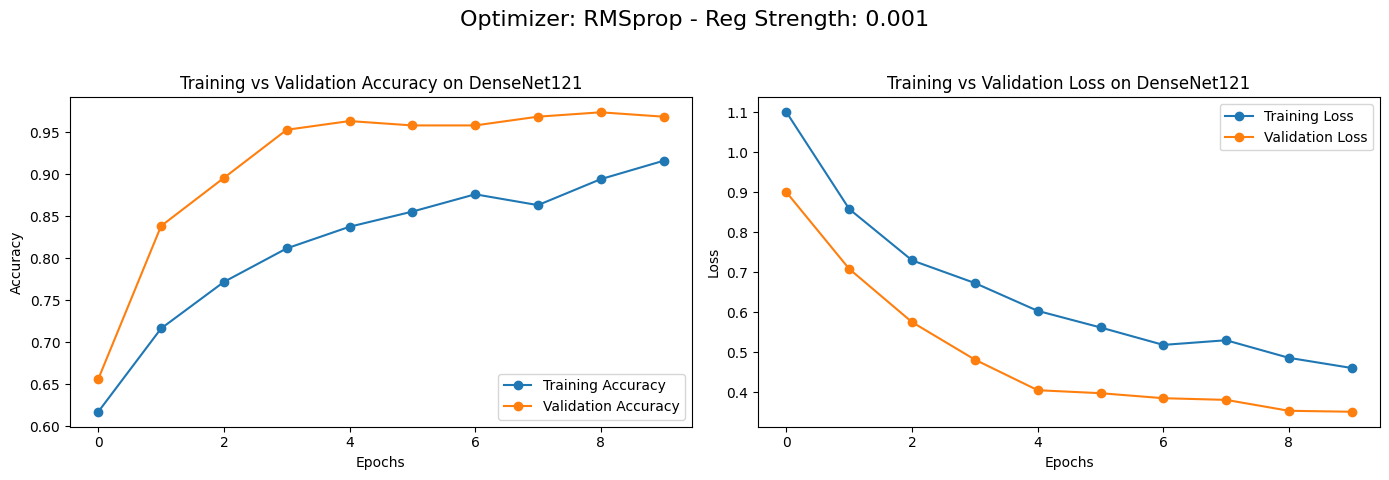

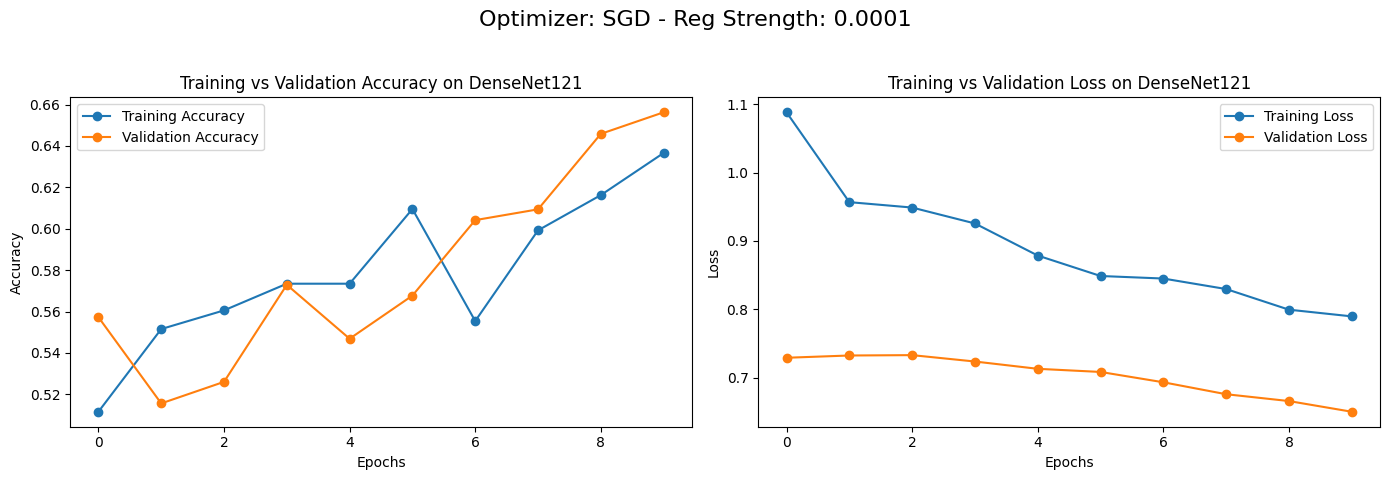

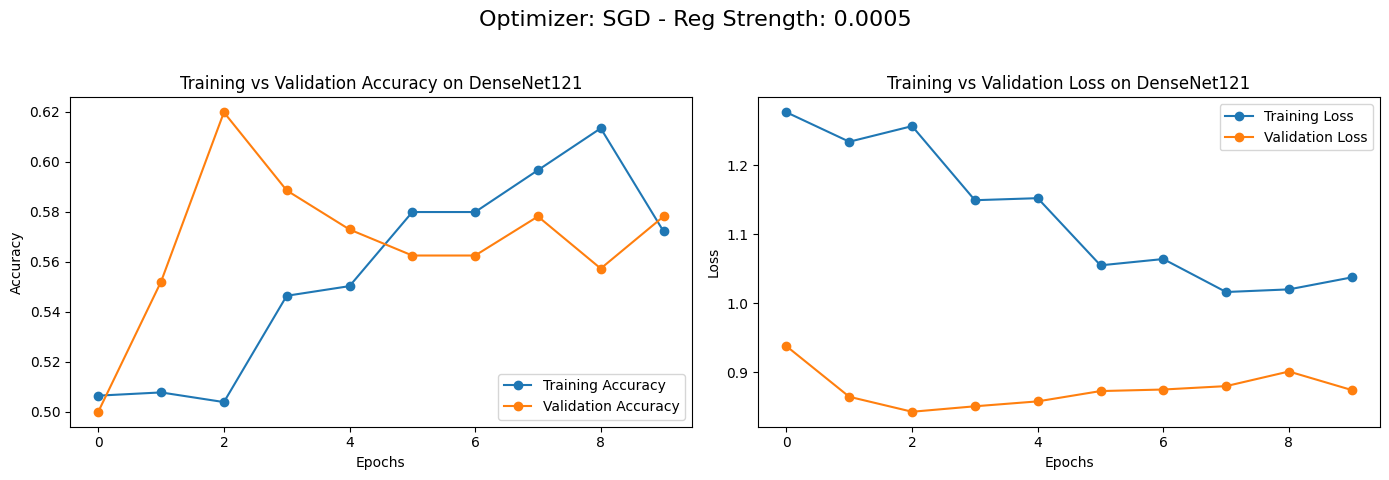

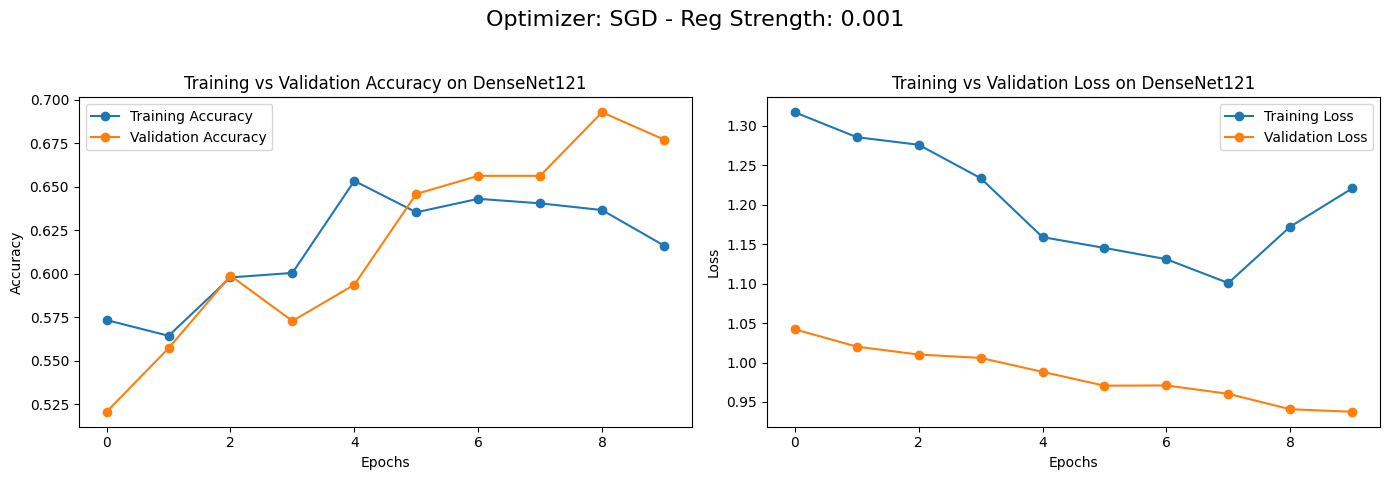

In [27]:
def plot_results_by_optimizer(optimizers, results):
    for optimizer in optimizers:
        optimizer_results = [r for r in results if r['optimizer'] == optimizer]
        for result in optimizer_results:
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            fig.suptitle(f'Optimizer: {optimizer} - Reg Strength: {result["reg_strength"]}', fontsize=16)
            
            axes[0].plot(result['history']['accuracy'], label='Training Accuracy', marker='o')
            axes[0].plot(result['history']['val_accuracy'], label='Validation Accuracy', marker='o')
            axes[0].set_title('Training vs Validation Accuracy on DenseNet121')
            axes[0].set_xlabel('Epochs')
            axes[0].set_ylabel('Accuracy')
            axes[0].legend()
            
            axes[1].plot(result['history']['loss'], label='Training Loss', marker='o')
            axes[1].plot(result['history']['val_loss'], label='Validation Loss', marker='o')
            axes[1].set_title('Training vs Validation Loss on DenseNet121')
            axes[1].set_xlabel('Epochs')
            axes[1].set_ylabel('Loss')
            axes[1].legend()
            
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])

            save_path = "Plots/Needs Respray/DenseNet121/"
            fig.savefig(f"{save_path}{optimizer}_{result['reg_strength']}.png")
            
            plt.show()

plot_results_by_optimizer(optimizers, results_densenet)

When evaluating machine learning models using training and validation graphs, there are specific patterns and indicators that can suggest whether a model is overfitting:

 * Overfitting is indicated by a significant and increasing gap between training and validation accuracy. The training accuracy continues to improve while the validation accuracy stagnates or declines.
 * A model that generalizes well will show a validation loss that decreases alongside the training loss. Signs of overfitting include a validation loss that begins to increase or fluctuates widely while the training loss continues to decrease.
 * Some degree of fluctuation in validation metrics is normal, but erratic or extreme changes can indicate issues. If the validation loss or accuracy plateaus early while training metrics continue to improve, this could be a sign that the model is no longer learning generalizable patterns.

Based on the graphs, the following configurations did not show significant signs of overfitting and displayed characteristics of good generalization:

 * VGG16 Model with Adam, Reg Strength: 0.0001
 * VGG16 Model with Adam, Reg Strength: 0.0005
 * VGG16 Model with SGD, Reg Strength: 0.0005
 * Inception-v3 Model with SGD, Reg Strength: 0.0001
 * Inception-v3 Model with Adam, Reg Strength: 0.0005
 * DenseNet121 Model with SGD, Reg Strength: 0.001
 * DenseNet121 Model with SGD, Reg Strength: 0.0005